# **DEEP LEARNING EXAM**

Names: NTEGANO Bahenda Yvon Dylan \
ID: 515657

## IMPORTS
Import of the libraries that will be used throughout the project.

In [84]:
%pip install visualkeras > /dev/null 2>&1

Note: you may need to restart the kernel to use updated packages.


The system cannot find the path specified.


In [85]:
! pip install optuna 

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: C:\Users\ENVY\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [86]:
import urllib.request
import zipfile
import pickle as pk

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

import keras
from keras.models import Model
from keras.layers import Input, Lambda, Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D, concatenate
import visualkeras
from tensorflow.keras.optimizers import Adam
import optuna

import tensorflow as tf

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

## LOADING DATA

In [87]:
# ZIP data URL from GitHub
zip_url = "https://github.com/dylanbahenda/DL-ANN/raw/main/input_data.zip"

# Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)

# Unzip the folder
target_folder = "temp"

# reading data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)
data_path = f"{target_folder}/input_data.pkl"

#Then use the following lines to read it:
with open(data_path, 'rb') as f:
    dd = pk.load(f)

imgs = dd['imgs']
masks = dd['masks']

### Data visualization


In [88]:
print(imgs.shape)
print(masks.shape)

(1305, 256, 256, 3)
(1305, 256, 256, 1)


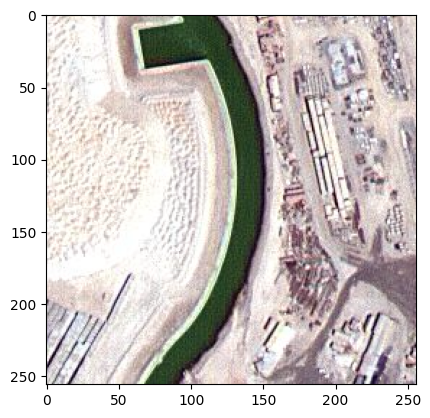

In [89]:
plt.imshow(imgs[0])

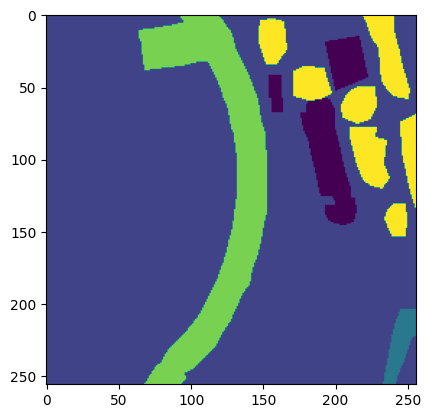

In [90]:
plt.imshow(masks[0])

## 1. MODEL

## 2. INPUT

In [91]:
"""# Horizontal flip
augmented_images.append(np.fliplr(image))
augmented_masks.append(np.fliplr(mask))

# 180 degree rotation
augmented_images.append(np.rot90(image, k=2))
augmented_masks.append(np.rot90(mask, k=2))

# 270 degree rotation
augmented_images.append(np.rot90(image, k=3))
augmented_masks.append(np.rot90(mask, k=3))"""

'# Horizontal flip\naugmented_images.append(np.fliplr(image))\naugmented_masks.append(np.fliplr(mask))\n\n# 180 degree rotation\naugmented_images.append(np.rot90(image, k=2))\naugmented_masks.append(np.rot90(mask, k=2))\n\n# 270 degree rotation\naugmented_images.append(np.rot90(image, k=3))\naugmented_masks.append(np.rot90(mask, k=3))'

### Preprocessing
Normalization by dividing the pixel values with the maximum.

In [92]:
# We want our values to be in the range [0,1]

imgs = imgs.astype(np.float32) / 255.0
masks = masks.astype(np.float32) / 5.0

print(f"Min and max pixel values: {imgs.min()}, {imgs.max()}")
print(f"Min and max masks values: {masks.min()}, {masks.max()}")

Min and max pixel values: 0.0, 1.0
Min and max masks values: 0.0, 1.0


Data augmentation by flipping and rotation.

In [93]:
# Function to augment data with separate flips and rotations
def augment_data(image, mask):
    augmented_images = []
    augmented_masks = []

    # Original
    augmented_images.append(image)
    augmented_masks.append(mask)

    # Vertical flip
    augmented_images.append(np.flipud(image))
    augmented_masks.append(np.flipud(mask))

    # 90 degree rotation
    augmented_images.append(np.rot90(image, k=1))
    augmented_masks.append(np.rot90(mask, k=1))

    return augmented_images, augmented_masks

# Function to apply augmentation to the entire dataset
def augment_dataset(images, masks):
    all_augmented_images = []
    all_augmented_masks = []

    for image, mask in zip(images, masks):
        augmented_images, augmented_masks = augment_data(image, mask)
        all_augmented_images.extend(augmented_images)
        all_augmented_masks.extend(augmented_masks)

    return np.array(all_augmented_images), np.array(all_augmented_masks)

# Apply augmentation to the dataset
augmented_images, augmented_masks = augment_dataset(imgs, masks)

We can see that each input image is a 3D tensor (256, 256, 3).

In [94]:
print(augmented_images.shape)
print(augmented_masks.shape)

(3915, 256, 256, 3)
(3915, 256, 256, 1)


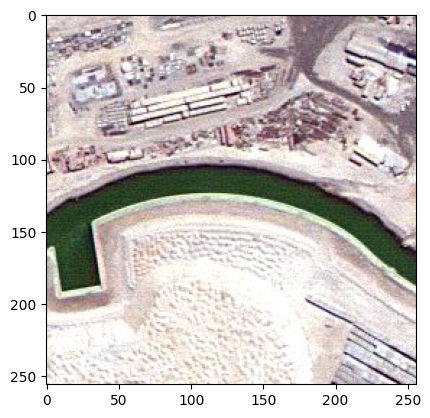

In [95]:
plt.imshow(augmented_images[2])

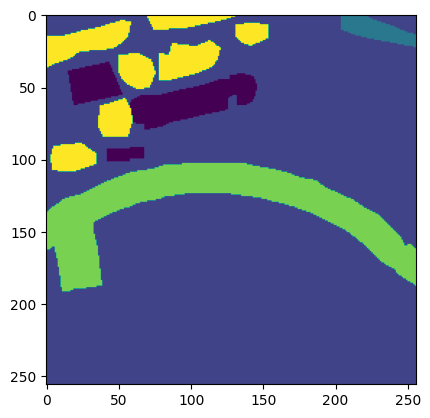

In [96]:
plt.imshow(augmented_masks[2])

In [97]:
def reduce_dataset(x_data, y_data, sample_size):
    # Ensure sample_size is not larger than the dataset
    sample_size = min(sample_size, x_data.shape[0])

    # Generate random indices
    indices = np.random.choice(x_data.shape[0], size=sample_size, replace=False)

    # Subset the data
    x_data_reduced = x_data[indices]
    y_data_reduced = y_data[indices]

    return x_data_reduced, y_data_reduced


sample_size = 2000
images_reduced, masks_reduced = reduce_dataset(augmented_images, augmented_masks, sample_size)

print(f"Reduced dataset size: {images_reduced.shape}, {masks_reduced.shape}")


Reduced dataset size: (2000, 256, 256, 3), (2000, 256, 256, 1)


### Train/Test split

In [98]:
x_train, x_test, y_train, y_test = train_test_split(
    augmented_images,
    augmented_masks,
    test_size = 0.2,
    random_state = 42
)

## 3. OUTPUT

## 4. LOSS

## 5. MODEL CONFIGURATION

In [99]:
# Input layer
inputs = Input(shape=(256, 256, 3))

# Encoder
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
p1 = MaxPooling2D((2, 2)) (c1)

# Bottleneck
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)

# Decoder
u3 = Conv2DTranspose(8, (2, 2), strides=(2,2) ,padding='same') (c2)
u3 = concatenate([u3, c1], axis=3)
c3 = Conv2D(8, (3, 3), activation='relu', padding='same') (u3)

outputs = Conv2D(1, (1, 1),activation='relu', )(c3)
# outputs = Lambda(lambda x: tf.clip_by_value(x * 5, 0, 5), output_shape=(256, 256, 1))(outputs)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_132 (Conv2D) │ (None, 256, 256,  │        224 │ input_layer_6[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 128, 128,  │          0 │ conv2d_132[0][0]  │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_133 (Conv2D) │ (None, 128, 128,  │      1,168 │ max_pooling2d_30… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_28 │ (None, 256, 256,  │        520 │ conv2d_133[0][0]  │
│ (Conv2DTranspose)   │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_28      │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 16)               │            │ conv2d_132[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_134 (Conv2D) │ (None, 256, 256,  │      1,160 │ concatenate_28[0… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_135 (Conv2D) │ (None, 256, 256,  │          9 │ conv2d_134[0][0]  │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,081 (12.04 KB)

 Trainable params: 3,081 (12.04 KB)

 Non-trainable params: 0 (0.00 B)

In [100]:
history = model.fit(
    x_train,
    y_train,
    validation_split = 0.2,
    batch_size=32,
    epochs=10
)

89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 381ms/step - loss: 0.1060 - val_loss: 0.0266


In [101]:
test_loss = model.evaluate(x_test, y_test)
print(f'Test loss: {test_loss}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0259
Test loss: 0.027239477261900902


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step
(783, 256, 256, 1)


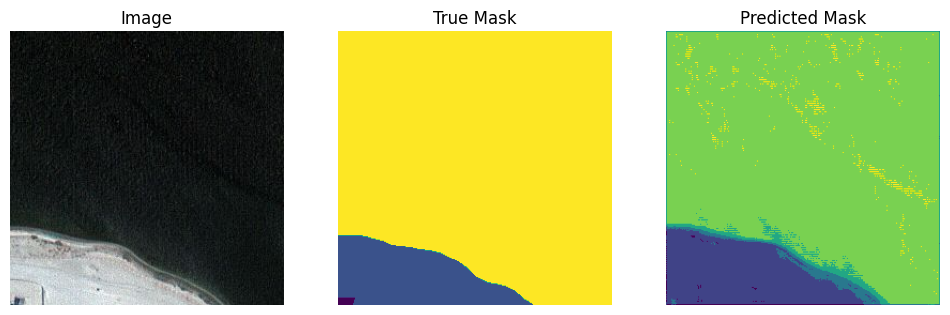

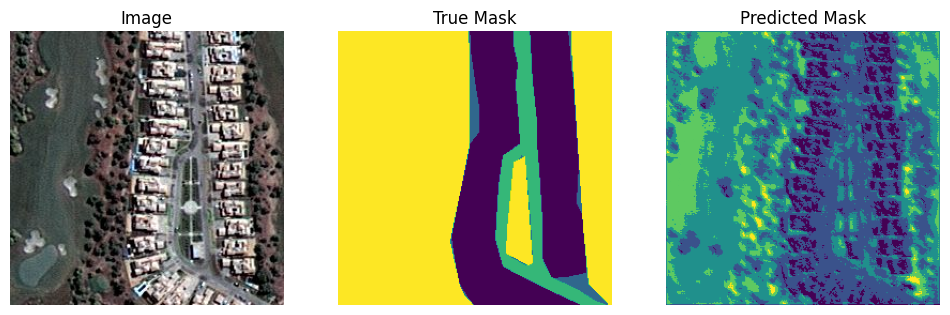

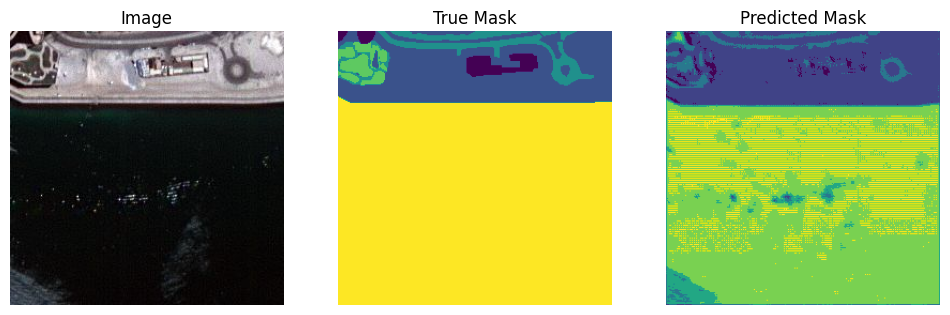

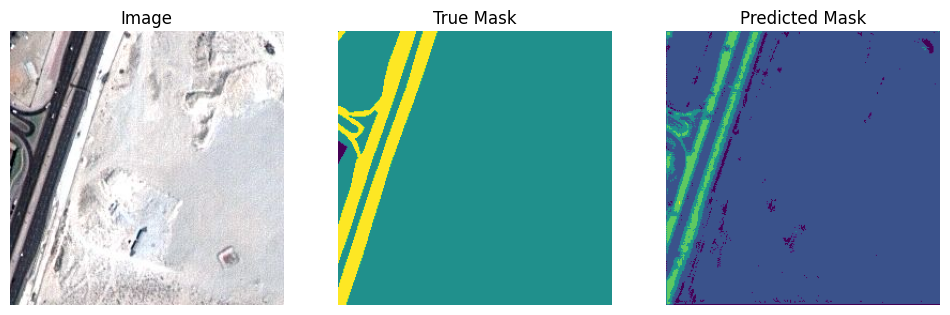

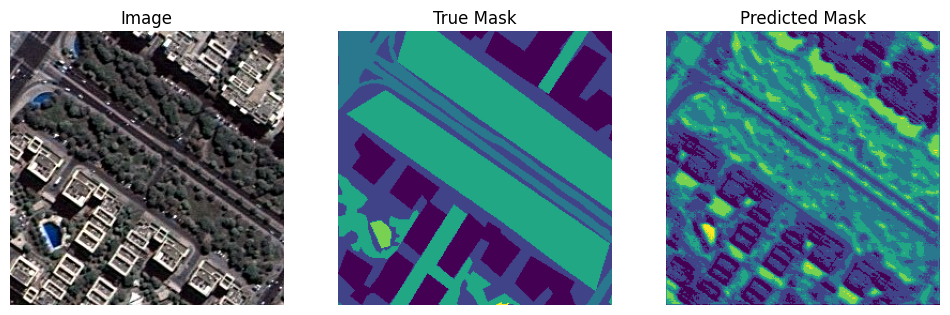

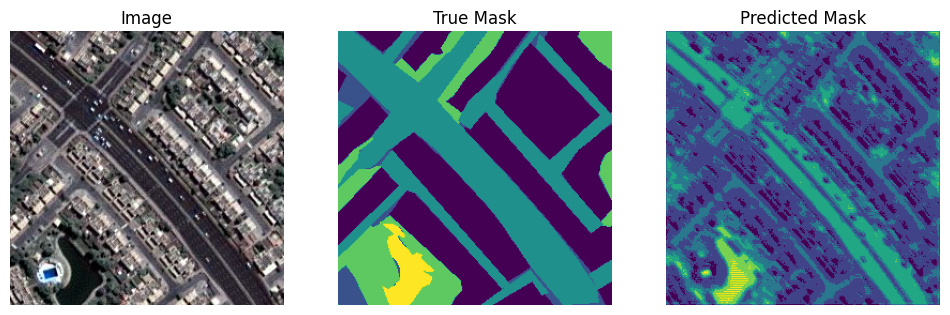

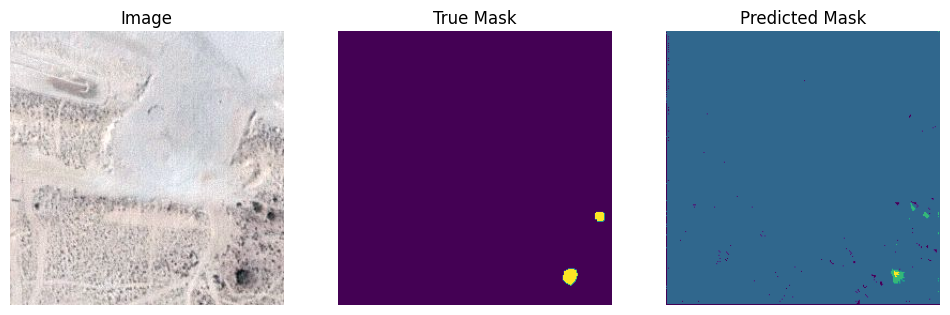

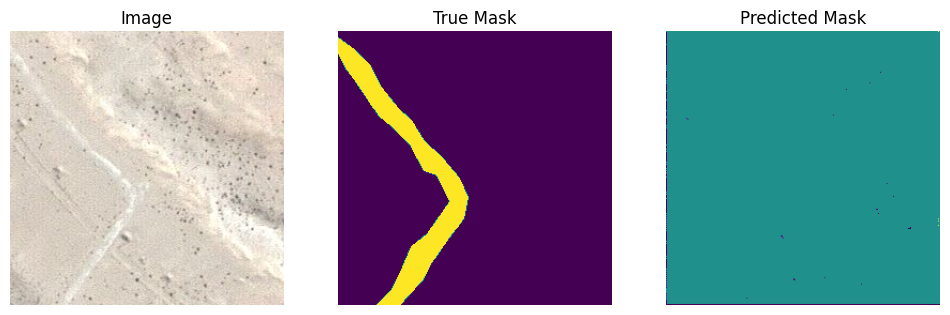

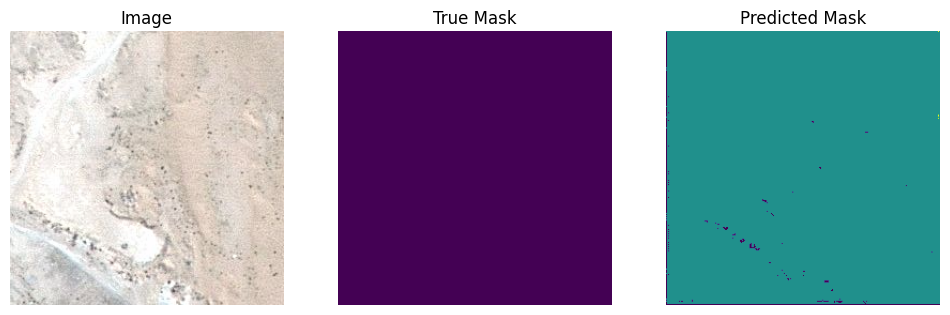

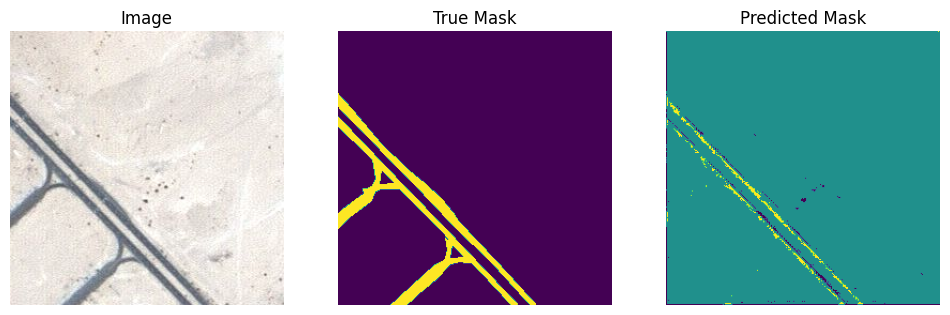

In [102]:
# Predict on test data
predictions = model.predict(x_test)

# Define thresholds to map normalized values to discrete class labels
thresholds = np.linspace(0, 1, 7)  # 6 thresholds for 6 classes

# Use numpy's digitize to map each value to the appropriate class
pred_discrete = np.digitize(predictions, bins=thresholds, right=True)

# Clip values to be within the range [0, 5]
predictions = np.clip(pred_discrete - 1, 0, 5)

# Print the shape of the predictions
print(predictions.shape)

def display_sample(x, y, pred, index):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(x[index])
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(y[index])
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(pred[index])
    plt.axis('off')

    plt.show()

# Display a few examples
for i in range(0, 10):
    display_sample(x=x_test, y=y_test, pred=predictions, index=i)

In [103]:
def build_unet(params):
    input_shape = (256, 256, 3)

    # Extract hyperparameters
    conv1_filters = params['conv1_filters']
    conv2_filters = params['conv2_filters']
    conv3_filters = params['conv3_filters']
    conv4_filters = params['conv4_filters']
    
    conv5_filters = params['conv5_filters']

    up6_filters = params['up6_filters']
    up7_filters = params['up7_filters']
    up8_filters = params['up8_filters']
    up9_filters = params['up9_filters']

    inputs = Input(shape=input_shape, dtype='float32', name='input')

    # Encoder
    conv1 = Conv2D(conv1_filters, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(conv1_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(conv2_filters, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(conv2_filters, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(conv3_filters, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(conv3_filters, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(conv4_filters, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(conv4_filters, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(conv5_filters, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(conv5_filters, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder
    up6 = Conv2DTranspose(up6_filters, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(up6_filters, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(up6_filters, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(up7_filters, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(up7_filters, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(up7_filters, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(up8_filters, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(up8_filters, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(up8_filters, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(up9_filters, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(up9_filters, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(up9_filters, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, (1, 1), activation='relu')(conv9)
    outputs = Lambda(lambda x: tf.clip_by_value(x * 5, 0, 5), output_shape=(256, 256, 1))(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [104]:
def objective(trial):
    conv1_filters = trial.suggest_int('conv1_filters', 8, 16, step=4)
    conv2_filters = trial.suggest_int('conv2_filters', 12, 20, step=4)
    conv3_filters = trial.suggest_int('conv3_filters', 16, 24, step=4)
    conv4_filters = trial.suggest_int('conv4_filters', 20, 28, step=4)

    conv5_filters = trial.suggest_int('conv5_filters', 24, 32, step=4)

    up6_filters = trial.suggest_int('up6_filters', 20, 28, step=4)
    up7_filters = trial.suggest_int('up7_filters', 16, 24, step=4)
    up8_filters = trial.suggest_int('up8_filters', 12, 20, step=4)
    up9_filters = trial.suggest_int('up9_filters', 8, 16, step=4)

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    print("Trial parameters", trial.params)

    # Build and train the model
    params = {
        'conv1_filters': conv1_filters,
        'conv2_filters': conv2_filters,
        'conv3_filters': conv3_filters,
        'conv4_filters': conv4_filters,
        'conv5_filters': conv5_filters,
        'up6_filters': up6_filters,
        'up7_filters': up7_filters,
        'up8_filters': up8_filters,
        'up9_filters': up9_filters
    }

    model = build_unet(params)

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    # Train the model
    history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Get the best validation loss from the history
    val_loss = min(history.history['val_loss'])  # Get the minimum validation loss

    return val_loss

# Create a study object and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2)

# Print the best hyperparameters
print(study.best_params)

[I 2024-07-23 23:45:57,430] A new study created in memory with name: no-name-58ff1863-2932-481e-bf4c-07697cb8bef3


Trial parameters {'conv1_filters': 12, 'conv2_filters': 16, 'conv3_filters': 20, 'conv4_filters': 20, 'conv5_filters': 32, 'up6_filters': 28, 'up7_filters': 24, 'up8_filters': 20, 'up9_filters': 16, 'learning_rate': 9.863133472535518e-05}
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - loss: 0.1502 - val_loss: 0.0779
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - loss: 0.0549 - val_loss: 0.0236
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - loss: 0.0233 - val_loss: 0.0220
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - loss: 0.0215 - val_loss: 0.0208
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - loss: 0.0210 - val_loss: 0.0203
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - loss: 0.0203 - val_loss: 0.0198
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - loss: 0.0200 - val_loss: 0.0195
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - loss: 0.0192 - val_loss: 0.0195
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - loss: 0.0192 - val_loss: 0.0

[I 2024-07-24 00:06:24,226] Trial 0 finished with value: 0.018999427556991577 and parameters: {'conv1_filters': 12, 'conv2_filters': 16, 'conv3_filters': 20, 'conv4_filters': 20, 'conv5_filters': 32, 'up6_filters': 28, 'up7_filters': 24, 'up8_filters': 20, 'up9_filters': 16, 'learning_rate': 9.863133472535518e-05}. Best is trial 0 with value: 0.018999427556991577.


Trial parameters {'conv1_filters': 16, 'conv2_filters': 20, 'conv3_filters': 20, 'conv4_filters': 20, 'conv5_filters': 24, 'up6_filters': 28, 'up7_filters': 20, 'up8_filters': 16, 'up9_filters': 8, 'learning_rate': 0.009376375882405717}
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - loss: 0.7950 - val_loss: 0.0264
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - loss: 0.0261 - val_loss: 0.0246
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - loss: 0.0240 - val_loss: 0.0232
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - loss: 0.0237 - val_loss: 0.0236
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - loss: 0.0218 - val_loss: 0.0212
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - loss: 0.0210 - val_loss: 0.0203
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - loss: 0.0204 - val_loss: 0.0219
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - loss: 0.0226 - val_loss: 0.0210
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - loss: 0.0205 - val_loss: 0.0197
E

[I 2024-07-24 00:23:18,416] Trial 1 finished with value: 0.019740434363484383 and parameters: {'conv1_filters': 16, 'conv2_filters': 20, 'conv3_filters': 20, 'conv4_filters': 20, 'conv5_filters': 24, 'up6_filters': 28, 'up7_filters': 20, 'up8_filters': 16, 'up9_filters': 8, 'learning_rate': 0.009376375882405717}. Best is trial 0 with value: 0.018999427556991577.


{'conv1_filters': 12, 'conv2_filters': 16, 'conv3_filters': 20, 'conv4_filters': 20, 'conv5_filters': 32, 'up6_filters': 28, 'up7_filters': 24, 'up8_filters': 20, 'up9_filters': 16, 'learning_rate': 9.863133472535518e-05}


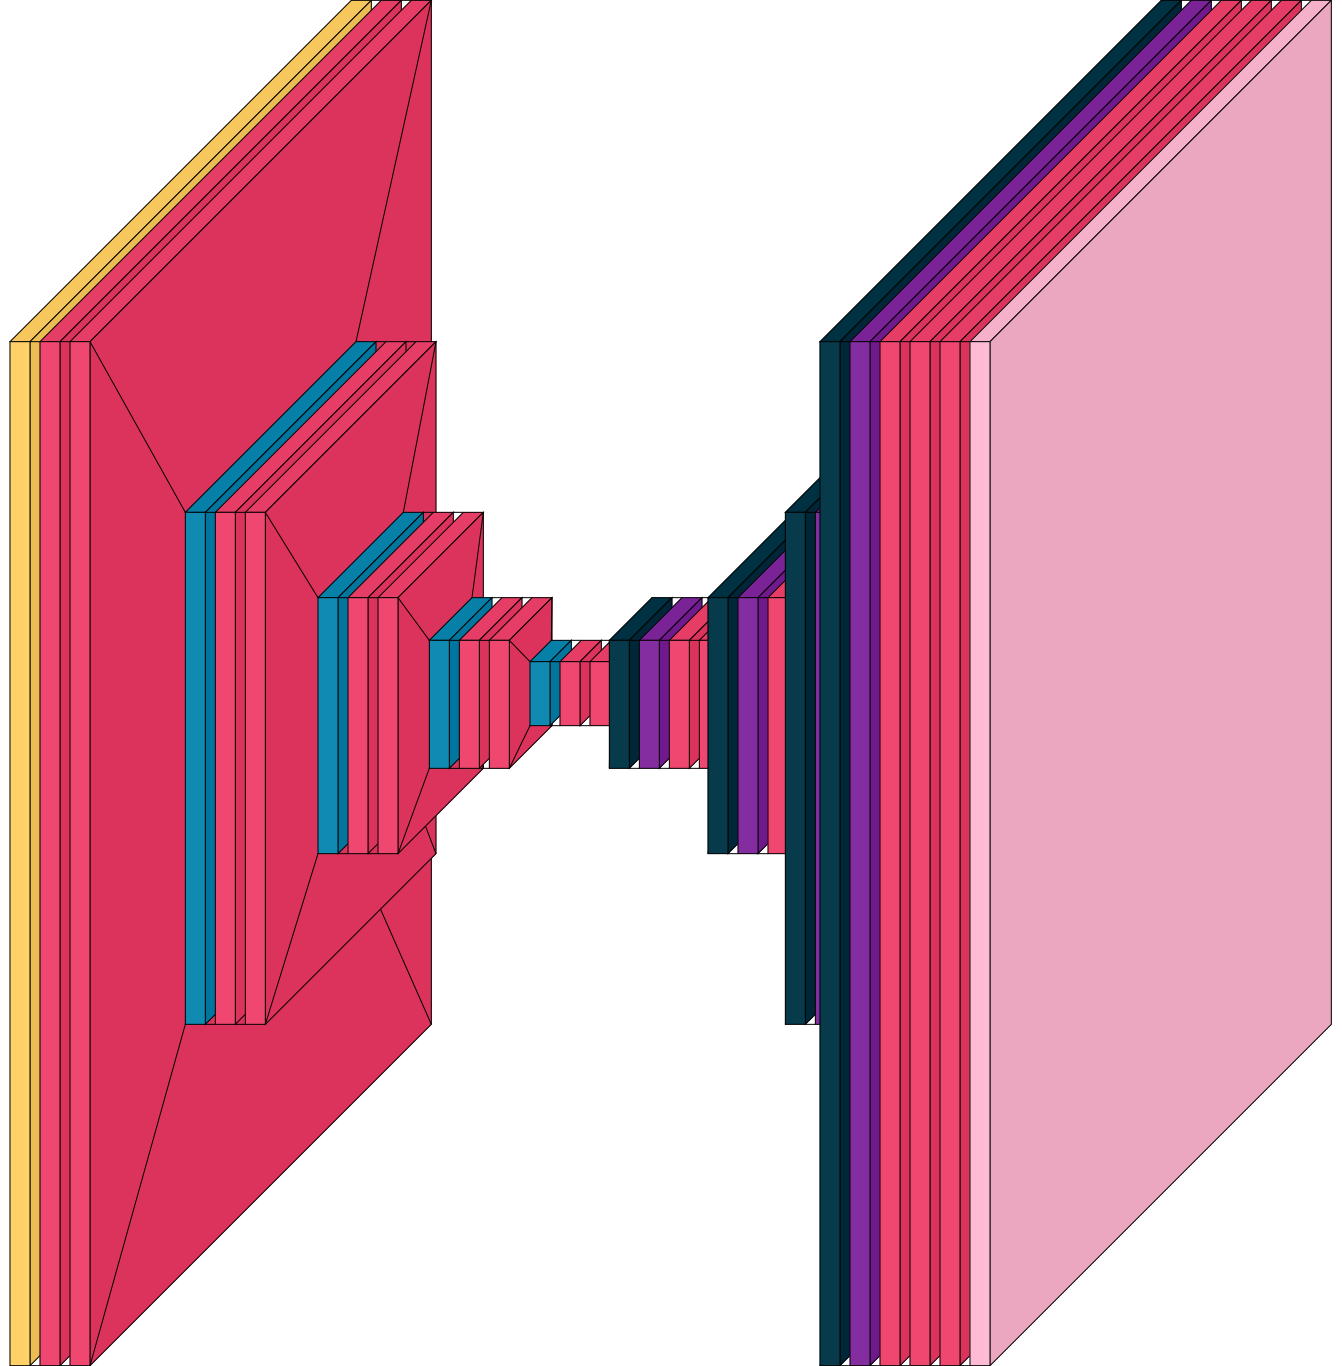

In [105]:
visualkeras.layered_view(best_model)

## 6. MODEL EVALUATION

In [106]:
# Build the best model with the best hyperparameters
best_params = study.best_params
best_model = build_unet(best_params)
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mse')

# Train the model on the full training set
history = best_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - loss: 0.1168 - val_loss: 0.0282
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - loss: 0.0255 - val_loss: 0.0227
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - loss: 0.0225 - val_loss: 0.0217
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - loss: 0.0219 - val_loss: 0.0211
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - loss: 0.0215 - val_loss: 0.0200
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - loss: 0.0203 - val_loss: 0.0200
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - loss: 0.0196 - val_loss: 0.0203
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - loss: 0.0195 - val_loss: 0.0195
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - loss: 0.0192 - val_loss: 0.0190
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - loss: 0.0188 - val_loss: 0.0197


In [107]:
# Evaluate the model on the test set
test_loss = best_model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 340ms/step - loss: 0.0193
Test Loss: 0.02030721865594387


In [108]:
# Retrieve metrics from the history object
train_loss = history.history.get('loss', None)
val_loss = history.history.get('val_loss', None)

# Print the last training and validation accuracy
if train_loss and val_loss:
    print(f'Final Training Loss: {train_loss[-1]}')
    print(f'Final Validation Loss: {val_loss[-1]}')
else:
    print("Loss metrics not found in history.")

Final Training Loss: 0.01913171075284481
Final Validation Loss: 0.019670730456709862


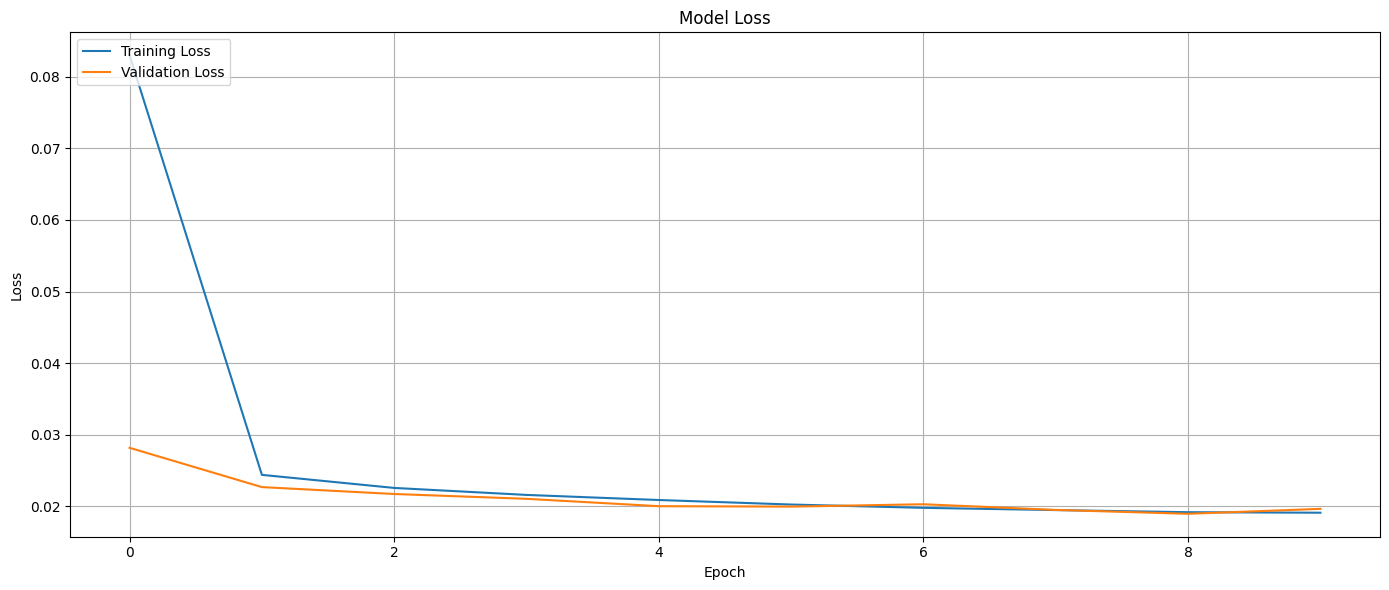

In [109]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(1, 1, figsize=(14, 6))  # 1 row, 2 columns

# Plot training & validation loss values
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper left')
ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

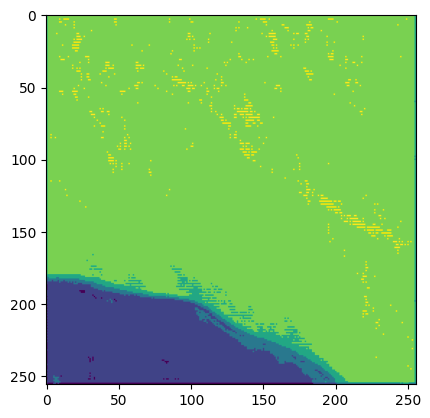

In [110]:
scaled_predictions = tf.clip_by_value(predictions[0] * 5, 0, 5)
predictions[0]

plt.imshow(predictions[0])

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 351ms/step
(783, 256, 256, 1)


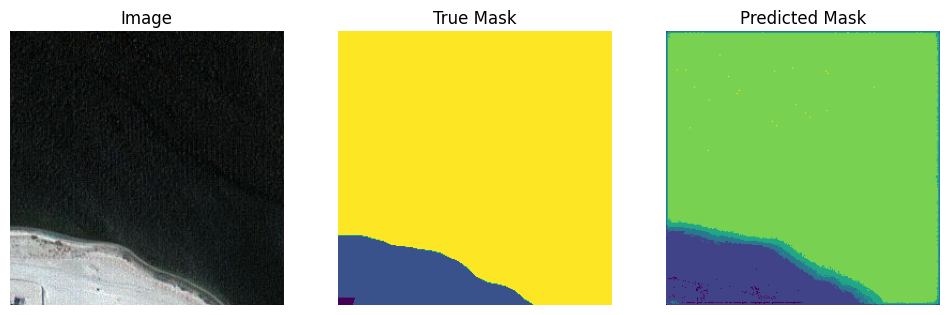

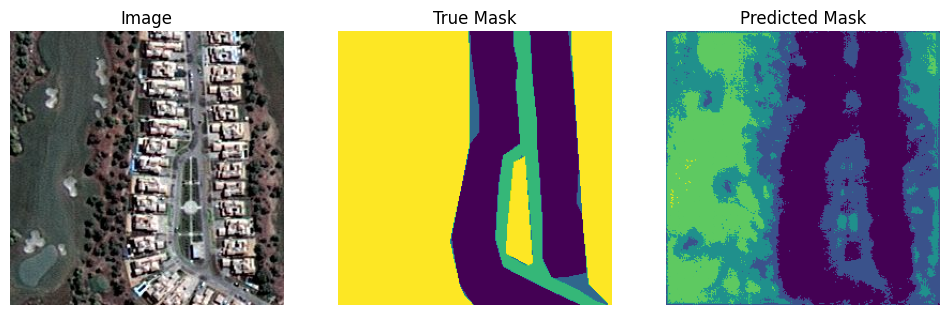

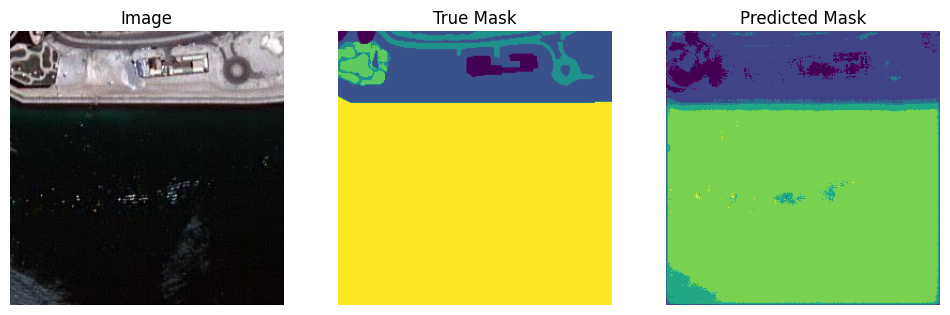

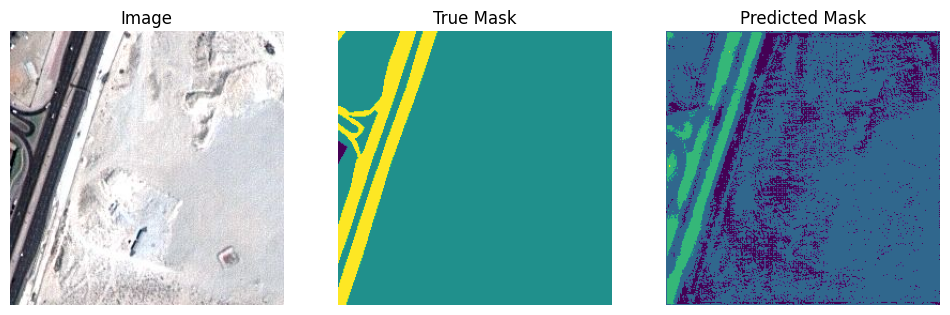

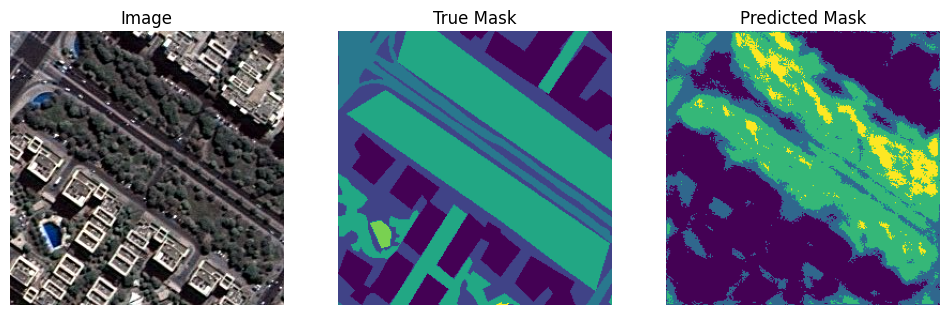

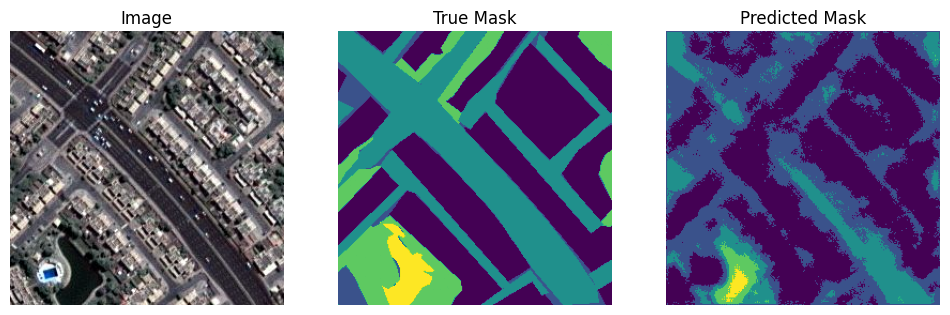

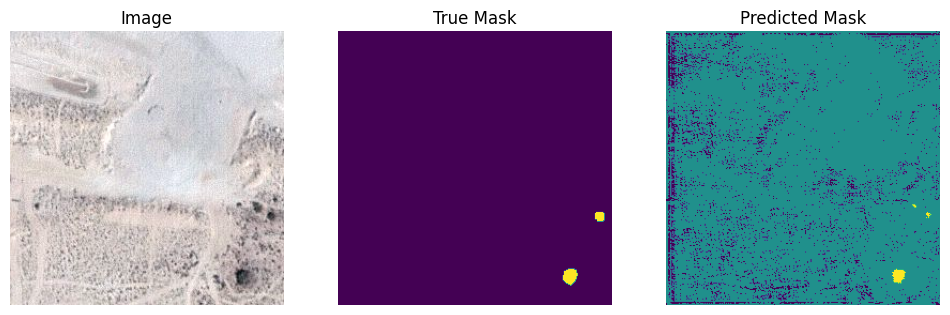

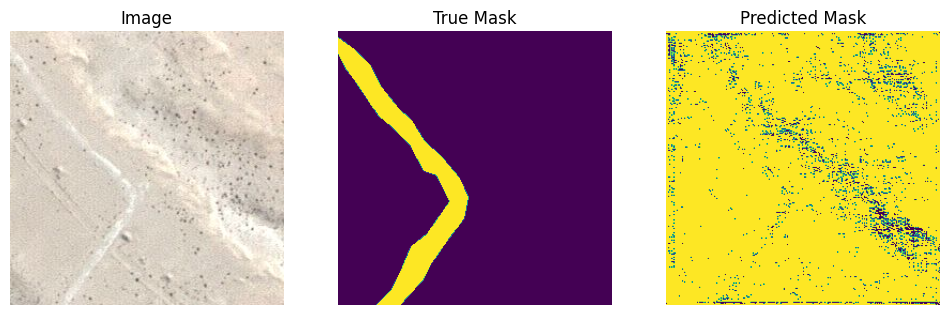

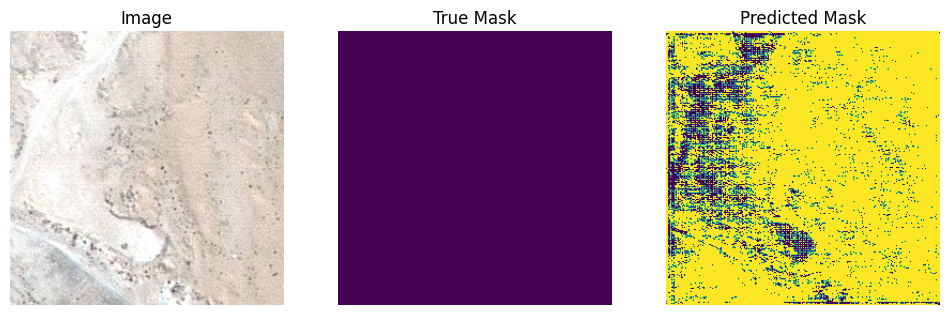

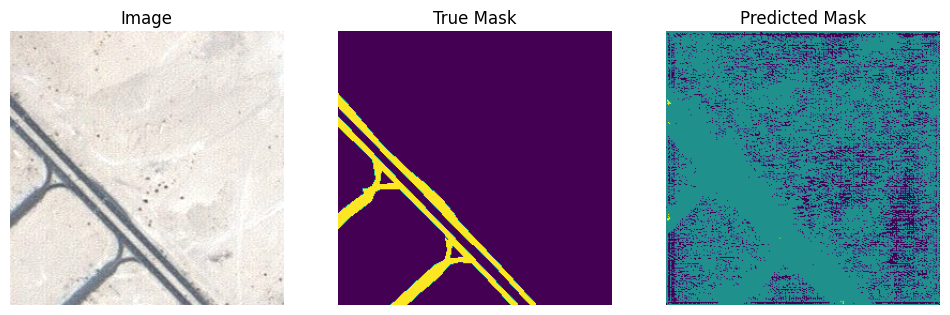

In [111]:
# Predict on test data
predictions = best_model.predict(x_test)

# Define thresholds to map normalized values to discrete class labels
thresholds = np.linspace(0, 1, 7)  # 6 thresholds for 6 classes

# Use numpy's digitize to map each value to the appropriate class
pred_discrete = np.digitize(predictions, bins=thresholds, right=True)

# Clip values to be within the range [0, 5]
predictions = np.clip(pred_discrete - 1, 0, 5)


# Print the shape of the predictions
print(predictions.shape)

def display_sample(x, y, pred, index):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(x[index])
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(y[index])
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(pred[index])
    plt.axis('off')

    plt.show()

# Display a few examples
for i in range(0, 10):
    display_sample(x=x_test, y=y_test, pred=predictions, index=i)